# 

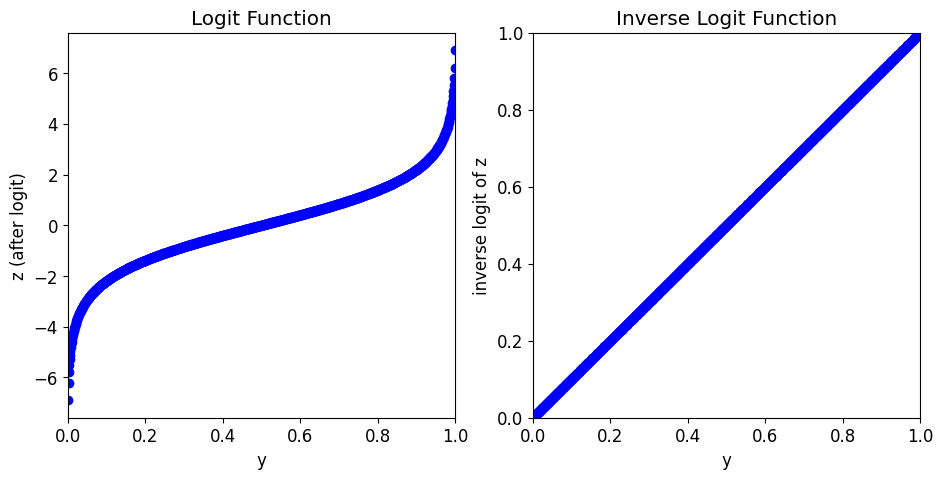

In [28]:
# 03_03_logit

import matplotlib.pyplot as plt
import numpy as np

values = np.arange(0.001, 1, 0.001, dtype=float)
logit = np.log(values / (1 - values))
inverse_logit = np.exp(logit) / (1 + np.exp(logit))

fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(11, 5))

fig1 = ax[0, 0]
fig1.scatter(values, logit, c="blue")
fig1.set_xlabel("y")
fig1.set_ylabel("z (after logit)")
fig1.set_xlim(0, 1)
fig1.set_title("Logit Function")

fig2 = ax[0, 1]
fig2.scatter(values, inverse_logit, c="blue")
fig2.set_xlabel("y")
fig2.set_ylabel("inverse logit of z")
fig2.set_xlim(0, 1)
fig2.set_ylim(0, 1)
fig2.set_title("Inverse Logit Function")
plt.show()


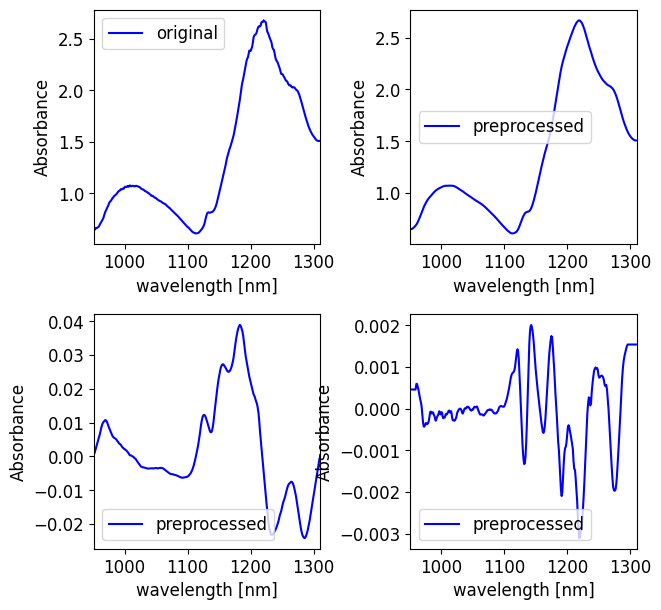

In [ ]:
# 03_04_sg

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.signal import savgol_filter

# SG法の設定値
window_length = 21  # 窓枠の数
poly_order = 2  # 多項式の次数
deriv = 0  # 微分次数 (0 は微分なし)
plot_spectra_number = 12  # 表示するスペクトルのサンプル番号 (0, 1, ..., 227)

csv_path = Path("dataset/sample_spectra_dataset.csv")
preprocessed_csv_path0 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{deriv}.csv"
)
preprocessed_csv_path1 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{1}.csv"
)
preprocessed_csv_path2 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{2}.csv"
)

# データセットの読み込み
x = pl.read_csv(csv_path).drop("")
# SG 法
preprocessed_x0 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=deriv
)
preprocessed_x1 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=1
)
preprocessed_x2 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=2
)
# pl.DataFrameに変換してcsvとして保存
preprocessed_x0 = pl.DataFrame(preprocessed_x0, schema=x.schema)
preprocessed_x1 = pl.DataFrame(preprocessed_x1, schema=x.schema)
preprocessed_x2 = pl.DataFrame(preprocessed_x2, schema=x.schema)
preprocessed_x0.with_row_index("").write_csv(
    preprocessed_csv_path0, quote_style="never"
)
preprocessed_x1.with_row_index("").write_csv(
    preprocessed_csv_path1, quote_style="never"
)
preprocessed_x2.with_row_index("").write_csv(
    preprocessed_csv_path2, quote_style="never"
)

# プロット
fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(7, 7))
wave_lengths = np.array(x.columns, dtype="float64")
fig1 = ax[0, 0]
fig1.plot(wave_lengths, x.row(plot_spectra_number), "b-", label="original")
fig1.set_xlabel("wavelength [nm]")
fig1.set_ylabel("Absorbance")
fig1.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig1.legend()

fig2 = ax[0, 1]
fig2.plot(
    wave_lengths,
    preprocessed_x0.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig2.set_xlabel("wavelength [nm]")
fig2.set_ylabel("Absorbance")
fig2.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig2.legend()

fig3 = ax[1, 0]
fig3.plot(
    wave_lengths,
    preprocessed_x1.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig3.set_xlabel("wavelength [nm]")
fig3.set_ylabel("Absorbance")
fig3.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig3.legend()

fig4 = ax[1, 1]
fig4.plot(
    wave_lengths,
    preprocessed_x2.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig4.set_xlabel("wavelength [nm]")
fig4.set_ylabel("Absorbance")
fig4.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig4.legend()

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()


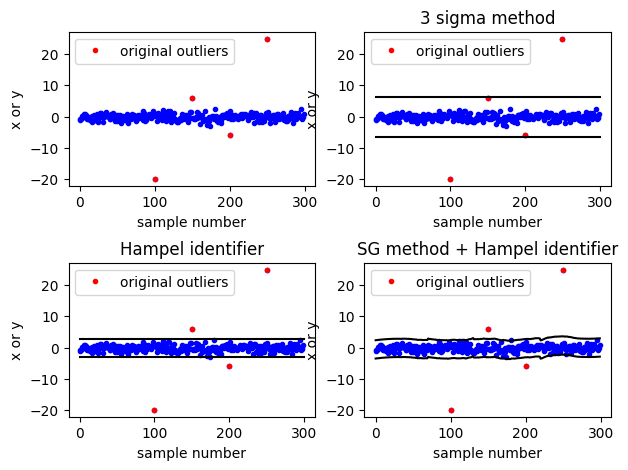

In [11]:
# 03_05_outlier

import matplotlib.pyplot as plt
import numpy as np
from numpy._typing._array_like import NDArray
from scipy.signal import savgol_filter

# 設定 ここから
type_of_samples = 0  # 仮想サンプルの種類 0:正規乱数、1:時系列
window_length = 61  # SG 法における窓枠の数
poly_order = 2  # SG 法における多項式の次数
deriv = 0  # SG 法における微分次数 (0 は微分なし)
number_of_samples = 300  # 仮想サンプルの数
noise_rate = 8  # SN比

rng = np.random.default_rng(seed=10)

if type_of_samples == 0:
    outliers = [-20, 6, -6, 25]  # 外れ値
    outlier_indices = [100, 150, 200, 250]  # 外れ値のインデックス
    x = rng.standard_normal(number_of_samples)
elif type_of_samples == 1:
    outliers = [1, 3, 10, -2]  # %外れ値
    outlier_indices = [80, 150, 200, 250]  # 外れ値のインデックス
    x: NDArray[np.float64] = np.sin(np.arange(number_of_samples) * np.pi / 50)
    noise: NDArray[np.float64] = rng.standard_normal(number_of_samples)
    noise = noise * (x.var() / noise_rate) ** 0.5
    x += noise
x[outlier_indices] = outliers  # 外れ値の追加

fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(7, 5))

fig1 = ax[0, 0]
fig1.plot(x, "b.")  # プロット
fig1.plot(
    outlier_indices, x[outlier_indices], "r.", label="original outliers"
)  # プロット
fig1.set_xlabel("sample number")  # x 軸の名前
fig1.set_ylabel("x or y")  # y 軸の名前
fig1.legend()


# 3 sigma method
upper_3_sigma = x.mean() + 3 * x.std()
lower_3_sigma = x.mean() - 3 * x.std()
fig2 = ax[0, 1]
fig2.plot(x, "b.")
fig2.plot(outlier_indices, x[outlier_indices], "r.", label="original outliers")
fig2.plot([0, len(x)], [upper_3_sigma, upper_3_sigma], "k-")
fig2.plot([0, len(x)], [lower_3_sigma, lower_3_sigma], "k-")
fig2.set_xlabel("sample number")  # x 軸の名前
fig2.set_ylabel("x or y")  # y 軸の名前
fig2.set_title("3 sigma method")
fig2.legend()

# Hampel identifier
upper_hampel = np.median(x) + 3 * 1.4826 * np.median(np.absolute(x - np.median(x)))
lower_hampel = np.median(x) - 3 * 1.4826 * np.median(np.absolute(x - np.median(x)))
fig3 = ax[1, 0]
fig3.plot(x, "b.")
fig3.plot(outlier_indices, x[outlier_indices], "r.", label="original outliers")
fig3.plot([0, len(x)], [upper_hampel, upper_hampel], "k-")
fig3.plot([0, len(x)], [lower_hampel, lower_hampel], "k-")
fig3.set_xlabel("sample number")  # x 軸の名前
fig3.set_ylabel("x or y")  # y 軸の名前
fig3.set_title("Hampel identifier")
fig3.legend()

# SG method + Hampel identifier
preprocessed_x = savgol_filter(
    x, window_length=window_length, polyorder=poly_order, deriv=deriv
)  # SG 法
x_diff = x - preprocessed_x
upper_sg_hampel = (
    preprocessed_x
    + np.median(x_diff)
    + 3 * 1.4826 * np.median(np.absolute(x_diff - np.median(x_diff)))
)
lower_sg_hampel = (
    preprocessed_x
    + np.median(x_diff)
    - 3 * 1.4826 * np.median(np.absolute(x_diff - np.median(x_diff)))
)
fig4 = ax[1, 1]
fig4.plot(x, "b.")
fig4.plot(outlier_indices, x[outlier_indices], "r.", label="original outliers")
fig4.plot(range(len(x)), upper_sg_hampel, "k-")
fig4.plot(range(len(x)), lower_sg_hampel, "k-")
fig4.set_xlabel("sample number")  # x 軸の名前
fig4.set_ylabel("x or y")  # y 軸の名前
fig4.set_title("SG method + Hampel identifier")
fig4.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()  # 以上の設定で描画


In [ ]:
# 03_06 demo_elo_pls

import numpy as np
import polars as pl
from dcekit.learning import ensemble_outlier_sample_detection
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold

# Demonstration of Ensemble Learning Outlier sample detection (ELO)
# https://datachemeng.com/ensembleoutliersampledetection/
# https://www.sciencedirect.com/science/article/abs/pii/S0169743917305919

dataset = pl.read_csv("dataset/numerical_simulation_data.csv").drop("")
y = dataset.get_column("y").to_numpy()
x = dataset.drop("y").to_numpy()

# PLS
max_pls_component_number = 30
min_pls_components = np.arange(1, min(max_pls_component_number, x.shape[1]) + 1)
cross_validation = KFold(n_splits=2, random_state=9, shuffle=True)
cv_regressor = GridSearchCV(
    PLSRegression(), {"n_components": min_pls_components}, cv=cross_validation
)
number_of_sub_models = 100
max_iteration_number = 30
outlier_sample_flags = ensemble_outlier_sample_detection(
    cv_regressor,
    x,
    y,
    cv_flag=True,
    n_estimators=number_of_sub_models,
    iteration=max_iteration_number,
    autoscaling_flag=True,
    random_state=0,
)

outlier_sample_flags = pl.DataFrame(outlier_sample_flags)
outlier_sample_flags.columns = ["TRUE if outlier samples"]
outlier_sample_flags.write_csv(
    "dataset/outlier_sample_detection_results.csv", quote_style="never"
)


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


In [3]:
# 03_07 欠損値の補完(iGMR)

import polars as pl
from dcekit.generative_model import GMR


def calc_interpolated_values(
    model: GMR,
    x_row: list[float],
    normalized_x_row: list[float],
    x: pl.DataFrame,
) -> list[float]:
    """補完値の計算と挿入."""
    if None not in x_row:
        return x_row
    row_series = pl.Series(x_row)
    normalized_row_series = pl.Series(normalized_x_row)
    is_null_series = row_series.is_null()
    is_val_series = row_series.is_not_null()
    mode_of_estimated_mean, *_ = model.predict(
        normalized_row_series.filter(is_val_series).to_frame().transpose(),
        is_val_series.arg_true(),
        is_null_series.arg_true(),
    )

    interpolated_vals = pl.Series(mode_of_estimated_mean[0]) * pl.Series(
        x.std().row(0)
    ).filter(is_null_series) + pl.Series(x.mean().row(0)).filter(is_null_series)

    # Noneをinterpolated_valueに置換
    # for i, j in enumerate(is_null_series.arg_true()):
    return row_series.scatter(is_null_series.arg_true(), interpolated_vals).to_list()


# load dataset
x_wt_nulls = pl.read_csv("dataset/iris_with_nan.csv").drop("")
x = x_wt_nulls.drop_nulls()
# 正規化
normalized_x_wt_nulls = x_wt_nulls.with_columns(
    (pl.all() - pl.all().drop_nulls().mean()) / pl.all().drop_nulls().std()
)
normalized_x = x.with_columns((pl.all() - pl.all().mean()) / pl.all().std())
# 元/正規化データのrowデータ(リスト)のDataFrameを作成
rows_of_ori_and_normalized_x_df = x_wt_nulls.select(
    pl.concat_list(pl.all()).alias("x_row")
).hstack(
    normalized_x_wt_nulls.select(pl.concat_list(pl.all()).alias("normalized_x_row"))
)

max_num_of_compo = 20
covariance_types = ["full", "diag", "tied", "spherical"]
for i in range(iterations := 10):
    print(f"{i + 1} / {iterations}")
    # グリッドサーチで最適(BICが一番小さい)パラメータを取得.
    bic_values = pl.DataFrame(
        {
            "num_of_compo": [
                num_of_compo
                for _ in covariance_types
                for num_of_compo in range(max_num_of_compo)
            ],
            "cov_type": [
                cov_type
                for cov_type in covariance_types
                for _ in range(max_num_of_compo)
            ],
            "BIC": [
                GMR(num_of_compo + 1, cov_type, random_state=0)
                .fit(normalized_x)
                .bic(normalized_x)
                for cov_type in covariance_types
                for num_of_compo in range(max_num_of_compo)
            ],
        }
    ).sort(pl.col("BIC"))

    # GMM
    model = GMR(
        n_components=bic_values.item(0, "num_of_compo") + 1,
        covariance_type=bic_values.item(0, "cov_type"),
        random_state=0,
    )
    model.fit(normalized_x)

    # interpolation(補完).
    x = (
        rows_of_ori_and_normalized_x_df.select(
            pl.struct(pl.col("x_row"), pl.col("normalized_x_row"))
            .map_elements(
                lambda row_dict, model=model, x=x: calc_interpolated_values(
                    model,
                    row_dict["x_row"],
                    row_dict["normalized_x_row"],
                    x,
                )
            )
            .alias("x_row")
        )
        .with_columns(pl.col("x_row").list.to_struct(fields=x.columns))
        .unnest("x_row")
    )

    # 正規化データを更新
    normalized_x = x.with_columns((pl.all() - pl.all().mean()) / pl.all().std())
    # 元/正規化データのrowデータ(リスト)のDataFrameを更新
    next_normalized_x_rows = normalized_x.select(
        pl.concat_list(pl.all()).alias("normalized_x_row")
    ).get_column("normalized_x_row")
    rows_of_ori_and_normalized_x_df.replace_column(1, next_normalized_x_rows)

# save interpolated dataset
x.insert_column(
    0, pl.Series("", [f"sample_{i + 1}" for i in range(x.height)])
).write_csv("dataset/interpolated_dataset.csv", quote_style="never")

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [21]:
# 04_02  同じ値を多くもうt特徴量の削除
import numpy as np
import polars as pl

# 同じ値をもつサンプルの割合で特徴量を削除するためのしきい値
threshold_dup_value_rate = 0.8

x = pl.read_csv("dataset/descriptors_with_logS.csv").drop("", "logS")

print("最初の特徴量の数 :", x.width)
# 同じ値の割合が、threshold_dup_value_rate 以上の特徴量を削除
dup_val_rates = (
    x.select(
        pl.all()
        .value_counts(sort=True, normalize=True, name="dup_rate")
        .first()
        .struct.field("dup_rate")
        .name.keep()
    )
    .with_columns(pl.all() < threshold_dup_value_rate)
    .row(0)
)
x_selected = x[:, dup_val_rates]
print("削除後の特徴量の数 :", x_selected.width)

x_selected.insert_column(
    0, pl.Series("", [f"sample_{i + 1}" for i in range(x_selected.height)])
).write_csv("dataset/x_selected_same_value.csv", quote_style="never")  # 保存


最初の特徴量の数 : 200
削除後の特徴量の数 : 102


同じ値をもつサンプルの割合で削除後の特徴量の数 : 102
相関係数で削除後の特徴量の数 : 80


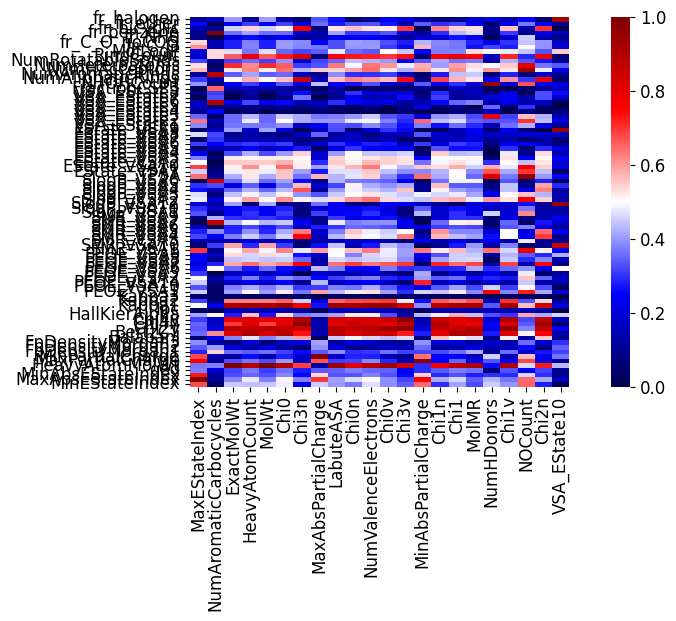

In [20]:
# 04_03 相関係数で特徴量削除

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

x = pl.read_csv("dataset/x_selected_same_value.csv").drop("")
print("同じ値をもつサンプルの割合で削除後の特徴量の数 :", x.width)

# 相関係数を求めて、絶対値に変換
abs_x_corr_df = (
    x.corr(ddof=1)
    .with_columns(pl.all().abs())
    .insert_column(0, pl.Series("", x.columns))
)
# unpivotしてから対角成分を0にする
unpivot_df = abs_x_corr_df.unpivot(
    index="", variable_name="variable", value_name="abs_corr"
).with_columns(
    pl.when(pl.col("").eq(pl.col("variable")))
    .then(0)
    .otherwise(pl.col("abs_corr"))
    .alias("abs_corr")
)

corr_threshold = 0.95
deleted_variables = []
for _ in x.columns:
    biggest_corr_index = unpivot_df["abs_corr"].arg_max()
    # サンプルコードと合わせるためにvar1と2を逆にしている
    var2, var1, biggest_corr = unpivot_df.row(biggest_corr_index)
    if biggest_corr < corr_threshold:
        break
    sum_of_var1_corr = abs_x_corr_df.get_column(var1).sum()
    sum_of_var2_corr = abs_x_corr_df.get_column(var2).sum()
    delete_var = var1 if sum_of_var1_corr >= sum_of_var2_corr else var2
    deleted_variables.append(delete_var)
    unpivot_df = unpivot_df.with_columns(
        pl.when(pl.col("").eq(delete_var) | pl.col("variable").eq(delete_var))
        .then(0)
        .otherwise(pl.col("abs_corr"))
        .alias("abs_corr")
    )

x_selected = x.drop(deleted_variables)
print("相関係数で削除後の特徴量の数 :", x_selected.width)

x_selected.insert_column(
    0, pl.Series("", [f"sample_{i + 1}" for i in range(x_selected.height)])
).write_csv("dataset/x_selected_correlation_deleting.csv", quote_style="never")

similarity_matrix = abs_x_corr_df.select(["", *deleted_variables]).filter(
    pl.col("").is_in(x_selected.columns)
)

# ヒートマップ
sns.heatmap(
    similarity_matrix.to_pandas().set_index(""),
    vmax=1,
    vmin=0,
    cmap="seismic",
    xticklabels=1,
    yticklabels=1,
)
plt.xlim([0, similarity_matrix.width])
plt.ylim([0, similarity_matrix.height])
plt.show()

similarity_matrix.write_csv(
    "dataset/similarity_matrix_correlation_deleting.csv", quote_style="never"
)


同じ値をもつサンプルの割合で削除後の特徴量の数 : 102
相関係数に基づいてクラスタリングした後の特徴量クラスターの数: 82


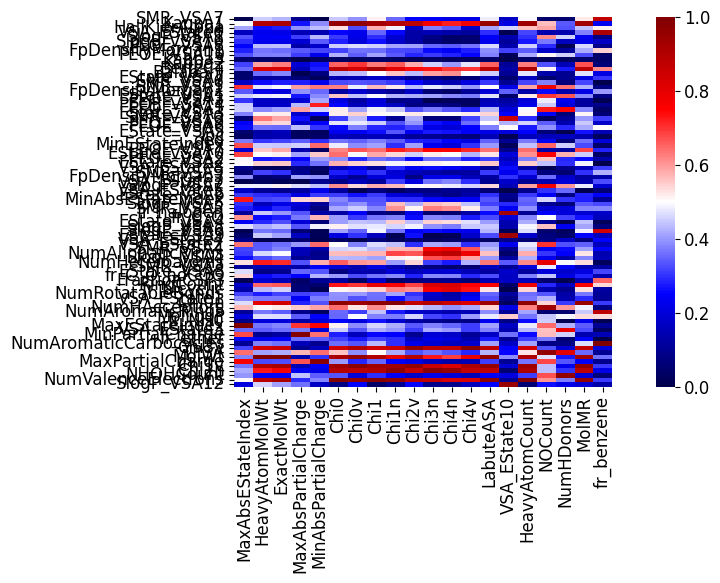

In [ ]:
# 04_04 相関係数で特徴量のクラスタリング
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

x = pl.read_csv("dataset/x_selected_same_value.csv").drop("")
print("同じ値をもつサンプルの割合で削除後の特徴量の数 :", x.width)

# 相関係数を求めて、絶対値に変換
abs_x_corr_df = (
    x.corr(ddof=1)
    .with_columns(pl.all().abs())
    .insert_column(0, pl.Series("", x.columns))
)
# unpivot
unpivot_df = abs_x_corr_df.unpivot(
    index="", variable_name="variable", value_name="abs_corr"
).with_columns(
    (1 / pl.col("abs_corr")).alias("distance_in_x"),
    # 対角成分を10の10乗にする
    pl.when(pl.col("").eq(pl.col("variable")))
    .then(10**10)
    .otherwise(pl.col("abs_corr"))
    .alias("abs_corr"),
)

# 相関係数に基づくクラスタリング
corr_threshold = 0.95
clustering = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",
    compute_full_tree=True,
    distance_threshold=1 / corr_threshold,
    linkage="complete",
)

# .clear(abs_x_corr_df.height)
clustering.fit(
    pl.DataFrame([[1] * abs_x_corr_df.height] * abs_x_corr_df.width, orient="col")
    / abs_x_corr_df.drop("")
)
cluster_numbers_df = pl.DataFrame(
    clustering.labels_, schema=["cluster_number"]
).insert_column(0, pl.Series("", x.columns))
cluster_numbers_df.write_csv(
    "dataset/cluster_numbers_correlation.csv", quote_style="never"
)
print(
    f"相関係数に基づいてクラスタリングした後の特徴量クラスターの数: {cluster_numbers_df.n_unique('cluster_number')}"  # noqa: E501
)

# クラスターごとに一つの特徴量を選択
selected_variables = (
    cluster_numbers_df.unique(
        subset="cluster_number", keep="first", maintain_order=True
    )
    .sort("cluster_number")
    .get_column("")
).to_list()
deleted_variables = cluster_numbers_df.filter(
    pl.col("").is_in(selected_variables).not_()
).get_column("")
x_selected = x.select(selected_variables).insert_column(
    0, pl.Series("", [f"sample_{i + 1}" for i in range(x.height)])
)
x_selected.write_csv(
    "dataset/x_selected_correlation_clustering.csv", quote_style="never"
)

similarity_matrix = (
    abs_x_corr_df.select(["", *deleted_variables.to_list()])
    .filter(pl.col("").is_in(selected_variables))
    .sort(pl.col("").cast(pl.Enum(selected_variables)))
)
col_list = similarity_matrix.columns
col_list[0] = ""
similarity_matrix.columns = col_list

# ヒートマップ
plt.rcParams["font.size"] = 12
sns.heatmap(
    similarity_matrix.to_pandas().set_index(""),
    vmax=1,
    vmin=0,
    cmap="seismic",
    xticklabels=1,
    yticklabels=1,
)
plt.xlim([0, similarity_matrix.shape[1]])
plt.ylim([0, similarity_matrix.shape[0]])
plt.show()

similarity_matrix.write_csv(
    "dataset/similarity_matrix_correlation_clustering.csv", quote_style="never"
)

# クラスターごとに特徴量を平均化
x_averaged = pl.DataFrame()
# クラスタ番号でgroup_byするためにtransposeする
x_t = (
    x.transpose(
        include_header=True,
        header_name="variable",
        column_names=[f"sample_{i + 1}" for i in range(x.height)],
    )
    .insert_column(0, cluster_numbers_df.get_column("cluster_number"))
    .sort("cluster_number")
)
for cluster_number, clustered_t_x in x_t.group_by(
    "cluster_number", maintain_order=True
):
    # transposeを戻す
    variables = clustered_t_x.get_column("variable")
    clustered_x = clustered_t_x.drop(["cluster_number", "variable"]).transpose(
        column_names=variables
    )
    # clustered_xの列数が1の場合はそのままx_averagedに格納
    # clustered_xの列数が2以上の場合は、各変数列毎にデータを正規化したあとに、
    # 行(サンプル)毎の平均をとったものをx_averagedに格納
    if clustered_x.width == 1:
        x_averaged.hstack(clustered_x, in_place=True)
    else:
        normalized_c_x = clustered_x.with_columns(
            (pl.all() - pl.all().mean()) / pl.all().std()
        )
        x_averaged.hstack(
            [
                normalized_c_x.mean_horizontal().rename(
                    f"mean_in_cluster_{cluster_number[0]}"
                )
            ],
            in_place=True,
        )

x_averaged.write_csv(
    "dataset/x_averaged_correlation_clustering.csv", quote_style="never"
)  # 保存


In [ ]:
# 04_05 GAPLS

import random
from itertools import batched
from typing import cast

import numpy as np
import polars as pl
from deap import base, creator, tools  # type: ignore[import-untyped]
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression

# シードの固定
random.seed(100)
# random.seed()  # noqa: ERA001

# データの読み込みと正規化
dataset = pl.read_csv("dataset/selected_descriptors_with_boiling_point.csv").drop("")
y_train_series = dataset.select(dataset.columns[0])  # 目的変数
x_train = dataset.drop(dataset.columns[0])  # 説明変数
# 正規化
normalized_x_train = x_train.with_columns((pl.all() - pl.all().mean()) / pl.all().std())
normalized_y_train_series = y_train_series.with_columns(
    (pl.all() - pl.all().mean()) / pl.all().std()
)

# GAPLSの設定
# deapのcreatorを使用してFitnessMaxとIndividualのクラスを作成
creator.create(  # for minimization, set weights as (-1.0,)
    "FitnessMax", base.Fitness, weights=(1.0,)
)
creator.create("Individual", list, fitness=creator.FitnessMax)

# toolboxに関数を登録
toolbox = base.Toolbox()


# 個体の生成用関数の登録
def create_individual(min_boundary: pl.Series, max_boundary: pl.Series) -> list[float]:
    """個体の生成用関数."""
    return [
        random.uniform(min_boundary[i], max_boundary[i])  # noqa: S311
        for i in range(len(min_boundary))
    ]


# 個体の生成
min_boundary = pl.Series([0.0] * x_train.width)
max_boundary = pl.Series([1.0] * x_train.width)
toolbox.register("create_individual", create_individual, min_boundary, max_boundary)
toolbox.register(
    "individual",
    tools.initIterate,
    creator.Individual,  # container
    toolbox.create_individual,  # generator
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# 評価関数の登録
def eval_one_max(  # noqa: PLR0913
    individual: creator.Individual,
    fold_number: int,
    threshold_of_variable_selection: float,
    normalized_x_train: pl.DataFrame,
    normalized_y_train: pl.DataFrame,
    y_train: pl.DataFrame,
) -> tuple:
    """個体の評価関数."""
    selected_normalized_x_train = normalized_x_train.select(
        [
            col
            for i, col in enumerate(normalized_x_train.columns)
            if individual[i] > threshold_of_variable_selection
        ]
    )
    # 選択された変数の数が0の場合は、適合度を-999にする
    if not len(selected_normalized_x_train.columns):
        return (-999,)

    # cross-validation
    min_pls_component = min(
        np.linalg.matrix_rank(selected_normalized_x_train), max_number_of_components
    )
    estimated_y_train_cv_df = y_train.clone().rename({"boiling_point": "y_train"})
    for pls_component in range(1, min_pls_component + 1):
        cross_val_predicts_np = model_selection.cross_val_predict(
            PLSRegression(n_components=pls_component),
            selected_normalized_x_train,  # type: ignore[arg-type]
            normalized_y_train,
            cv=fold_number,
        )
        estimated_y_train_cv_df = estimated_y_train_cv_df.with_columns(
            pl.Series(f"{pls_component}", cross_val_predicts_np.flatten())
        )

    # クロスバリデーションの結果を元のスケールに戻す
    estimated_y_train_cv_df = estimated_y_train_cv_df.with_columns(
        pl.exclude("y_train") * pl.col("y_train").std() + pl.col("y_train").mean()
    )
    # r2を計算

    r2_cv_all = estimated_y_train_cv_df.select(
        pl.exclude("y_train")
        .sub(pl.col("y_train"))
        .pow(2)
        .sum()
        .truediv(pl.col("y_train").sub(pl.col("y_train").mean()).pow(2).sum())
        .mul(-1)
        .add(1)
        .name.prefix("r2_")
    )
    return (r2_cv_all.max_horizontal().max(),)


toolbox.register(
    "evaluate",
    eval_one_max,
    fold_number=(fold_number := 5),  # クロスバリデーションのfold数
    threshold_of_variable_selection=(  # 染色体の0, 1を分ける閾値
        threshold_of_variable_selection := 0.5
    ),
    normalized_x_train=normalized_x_train,
    normalized_y_train=normalized_y_train_series,
    y_train=y_train_series,
)
# 2点交叉(Two-point crossover): 2個体のランダムで選択した遺伝子を入れ替える
toolbox.register("mate", tools.cxTwoPoint)
# 突然変異: indpbの確率で、個体の遺伝子を反転させる(特徴量の選択有無を反転)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
# 個体の選別方法: トーナメント選択で3個体の中から1個体を選択.
toolbox.register("select", tools.selTournament, tournsize=3)

print("Start of evolution")


def update_fitness(individual: creator.Individual) -> creator.Individual:
    """個体の適合度を更新する."""
    individual.fitness.values = toolbox.evaluate(individual)
    return individual


def mate(individual1: creator.Individual, individual2: creator.Individual) -> None:
    """個体の交叉."""
    toolbox.mate(individual1, individual2)
    del individual1.fitness.values, individual2.fitness.values


def mutate(individual: creator.Individual) -> None:
    """個体の突然変異."""
    toolbox.mutate(individual)
    del individual.fitness.values


num_of_population = 100  # GAの個体数
num_of_generation = 150  # GAの世代数
max_number_of_components = 10  # PLS の最大成分数
crossover_probability = 0.5
mutation_probability = 0.2
population = cast("list[creator.Individual]", toolbox.population(n=num_of_population))
for generation in range(num_of_generation + 1):
    print(f"-- Generation {generation} --")
    # 1世代目以降は変異させる
    if generation > 0:
        # トーナメント選択で、individual 3個体の中1個体を選択。population数分繰り返す
        offspring = toolbox.select(population, k=len(population))
        offspring = [toolbox.clone(child) for child in offspring]  # deepcopy

        # 親世代を変異させて、子世代を作成
        # 変異済みの判定はfitness.valuesを削除してnot fitness.valid = Trueで行う
        # 2個ずつ個体を取り出して、交叉を行う
        [
            mate(*children)  # type: ignore[func-returns-value]
            for children in batched(offspring, 2, strict=False)
            if len(children) != 1 and random.random() < crossover_probability  # noqa: S311
        ]
        # 突然変異
        [mutate(child) for child in offspring if random.random() < mutation_probability]  # type: ignore[func-returns-value]  # noqa: S311
        # 個体群を新世代に置き換え
        population = offspring

    num_of_updated_children = len(
        [child for child in population if not child.fitness.valid]
    )
    # 各個体の適合度を更新
    population = [
        child if child.fitness.valid else update_fitness(child) for child in population
    ]

    print(f"\tEvaluated {num_of_updated_children} individuals")

    fits: list[float] = [individual.fitness.values[0] for individual in population]
    length = len(population)
    mean = sum(fits) / length
    sum2 = sum(fit**2 for fit in fits)
    std = abs(sum2 / length - mean**2) ** 0.5

    print(f"\tMin {min(fits)}")
    print(f"\tMax {max(fits)}")
    print(f"\tAvg {mean}")
    print(f"\tStd {std}")

print("-- End of (successful) evolution --")

best_individual = tools.selBest(population, 1)[0]
floored_best_individual_df = pl.Series(best_individual)
selected_descriptors = x_train.select(
    col
    for i, col in enumerate(x_train.columns)
    if floored_best_individual_df[i] > threshold_of_variable_selection
)
selected_descriptors.insert_column(
    0, pl.Series("", [f"sample_{i + 1}" for i in range(selected_descriptors.height)])
).write_csv("dataset/gapls_selected_x.csv", quote_style="never")

/Users/sean/Documents/myscript/python-mi-for_chemical_engineering/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sean/Documents/myscript/python-mi-for_chemical_engineering/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Start of evolution
-- Generation 0 --
	Evaluated 100 individuals
	Min 0.23694873880810885
	Max 0.9216573391000578
	Avg 0.8574991169973991
	Std 0.07935917374953681
-- Generation 1 --
	Evaluated 61 individuals
	Min 0.733566919106341
	Max 0.9241956141711579
	Avg 0.8895590961170988
	Std 0.027559791378676556
-- Generation 2 --
	Evaluated 67 individuals
	Min 0.6991408579758521
	Max 0.9260451179977452
	Avg 0.8969459319348645
	Std 0.0318084476848447
-- Generation 3 --
	Evaluated 61 individuals
	Min 0.7822400943282936
	Max 0.9361104082370907
	Avg 0.9058877998790684
	Std 0.0217547458755978
-- Generation 4 --
	Evaluated 62 individuals
	Min 0.663289940215614
	Max 0.9314250990153212
	Avg 0.9072270557727188
	Std 0.03270990970085719
-- Generation 5 --
	Evaluated 65 individuals
	Min 0.5558696438748207
	Max 0.9371699978221655
	Avg 0.9058736251089896
	Std 0.048180252751083945
-- Generation 6 --
	Evaluated 55 individuals
	Min 0.6452876576071714
	Max 0.9371699978221656
	Avg 0.9167070545645393
	Std 0.03188

In [ ]:
# 04_05 GAPLS 並列実行版
from scripts import chap04_05_gapls

chap04_05_gapls.main()

In [ ]:
# 04_05 GASVR

import random
from itertools import batched
from typing import cast

import polars as pl
from deap import base, creator, tools  # type: ignore[import-untyped]
from sklearn import model_selection, svm  # noqa: F811

# シードの固定
random.seed(100)
# random.seed()  # noqa: ERA001

# データの読み込みと正規化
dataset = pl.read_csv("dataset/selected_descriptors_with_boiling_point.csv").drop("")
y_train_series = dataset.select(dataset.columns[0])  # 目的変数
x_train = dataset.drop(dataset.columns[0])  # 説明変数
# 正規化
normalized_x_train = x_train.with_columns((pl.all() - pl.all().mean()) / pl.all().std())
normalized_y_train_series = y_train_series.with_columns(
    (pl.all() - pl.all().mean()) / pl.all().std()
)

# GASVRの設定
# deapのcreatorを使用してFitnessMaxとIndividualのクラスを作成
creator.create(  # for minimization, set weights as (-1.0,)
    "FitnessMax", base.Fitness, weights=(1.0,)
)
creator.create("Individual", list, fitness=creator.FitnessMax)

# toolboxに登録する関数の準備
toolbox = base.Toolbox()
# 個体の生成用関数
# 末尾3つはSVRのハイパーパラメータ
# C, epsilon, gamma の範囲
min_boundary = pl.Series([0.0] * (x_train.width)).append(
    pl.Series([-5, -10, -20]).cast(pl.Float64)
)
max_boundary = pl.Series([1.0] * (x_train.width)).append(
    pl.Series([10, 0, 10]).cast(pl.Float64)
)


def create_individual(min_boundary: pl.Series, max_boundary: pl.Series) -> list:
    """個体の生成用関数."""
    return [
        random.uniform(min_boundary[i], max_boundary[i])  # noqa: S311
        for i in range(len(min_boundary))
    ]


# toolboxに関数を登録
toolbox.register("create_individual", create_individual, min_boundary, max_boundary)
toolbox.register(
    "individual",
    tools.initIterate,
    creator.Individual,  # container
    toolbox.create_individual,  # generator
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# 評価関数
def eval_one_max(  # noqa: PLR0913
    individual: creator.Individual,
    fold_number: int,
    threshold_of_variable_selection: float,
    normalized_x_train: pl.DataFrame,
    normalized_y_train_series: pl.Series,
    y_train_series: pl.Series,
) -> tuple[float]:
    """個体の評価関数."""
    selected_normalized_x_train = normalized_x_train.select(
        [
            col
            for i, col in enumerate(normalized_x_train.columns)
            if individual[i] > threshold_of_variable_selection
        ]
    )
    # 選択された変数の数が0の場合は、適合度を-999にする
    if not len(selected_normalized_x_train.columns):
        return (-999,)

    # cross-validation
    rounded_hyper_prams = pl.Series(individual).round()[-3:]
    model_in_cv = svm.SVR(
        kernel="rbf",
        C=2 ** rounded_hyper_prams.item(0),
        epsilon=2 ** rounded_hyper_prams.item(1),
        gamma=2 ** rounded_hyper_prams.item(2),
    )
    cross_val_predicts_np = model_selection.cross_val_predict(
        model_in_cv,
        selected_normalized_x_train,
        normalized_y_train_series,
        cv=fold_number,
    )
    estimated_y_train_in_cv_series = pl.Series(
        "cv_predict", cross_val_predicts_np.flatten()
    )
    # クロスバリデーションの結果を元のスケールに戻す
    estimated_y_train_in_cv_series = (
        estimated_y_train_in_cv_series * y_train_series.std() + y_train_series.mean()
    )
    # r2を計算
    r2_cv = (
        1
        - (estimated_y_train_in_cv_series - y_train_series).pow(2).sum()
        / (y_train_series - y_train_series.mean()).pow(2).sum()
    )

    return (r2_cv,)


# 評価関数を登録
toolbox.register(
    "evaluate",
    eval_one_max,
    fold_number=(fold_number := 5),  # クロスバリデーションのfold数
    threshold_of_variable_selection=(  # 染色体の0, 1を分ける閾値
        threshold_of_variable_selection := 0.5
    ),
    normalized_x_train=normalized_x_train,
    normalized_y_train_series=normalized_y_train_series.to_series(0),
    y_train_series=y_train_series.to_series(0),
)
# その他の関数はGAPLSと同じ
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


def update_fitness(individual: creator.Individual) -> creator.Individual:
    """個体の適合度を更新する."""
    individual.fitness.values = toolbox.evaluate(individual)
    return individual


def mate(individual1: creator.Individual, individual2: creator.Individual) -> None:
    """個体の交叉."""
    toolbox.mate(individual1, individual2)
    del individual1.fitness.values, individual2.fitness.values


def mutate(individual: creator.Individual) -> None:
    """個体の突然変異."""
    toolbox.mutate(individual)


# 最適化開始
print("Start of evolution")

num_of_population = 100  # GAの個体数
num_of_generation = 150  # GAの世代数
max_number_of_components = 10  # PLS の最大成分数
crossover_probability = 0.5
mutation_probability = 0.2
population = cast("list[creator.Individual]", toolbox.population(n=num_of_population))
for generation in range(num_of_generation + 1):
    print(f"-- Generation {generation} --")
    # 1世代目以降は変異させる
    if generation > 0:
        # トーナメント選択で、individual 3個体の中1個体を選択。population数分繰り返す
        offspring = toolbox.select(population, k=len(population))
        offspring = [toolbox.clone(child) for child in offspring]  # deepcopy

        # 親世代を変異させて、子世代を作成
        # 変異済みの判定はfitness.valuesを削除してnot fitness.valid = Trueで行う
        # 2個ずつ個体を取り出して、交叉を行う
        [
            mate(*children)  # type: ignore[func-returns-value]
            for children in batched(offspring, 2, strict=False)
            if len(children) != 1 and random.random() < crossover_probability  # noqa: S311
        ]
        # 突然変異
        [mutate(child) for child in offspring if random.random() < mutation_probability]  # type: ignore[func-returns-value]  # noqa: S311
        # 個体群を新世代に置き換え
        population = offspring

    num_of_updated_children = len(
        [child for child in population if not child.fitness.valid]
    )
    # 各個体の適合度を更新
    population = [
        child if child.fitness.valid else update_fitness(child) for child in population
    ]

    print(f"\tEvaluated {num_of_updated_children} individuals")

    fits: list[float] = [individual.fitness.values[0] for individual in population]
    length = len(population)
    mean = sum(fits) / length
    sum2 = sum(fit**2 for fit in fits)
    std = abs(sum2 / length - mean**2) ** 0.5

    print(f"\tMin {min(fits)}")
    print(f"\tMax {max(fits)}")
    print(f"\tAvg {mean}")
    print(f"\tStd {std}")

print("-- End of (successful) evolution --")

# 最適化結果のを保存
best_individual = tools.selBest(population, 1)[0]
best_individual_series = pl.Series(best_individual)
selected_descriptors = x_train.select(
    col
    for i, col in enumerate(x_train.columns)
    if best_individual_series[i] > threshold_of_variable_selection
)
selected_descriptors.insert_column(
    0, pl.Series("", [f"sample_{i + 1}" for i in range(selected_descriptors.height)])
).write_csv("dataset/gasvr_selected_x.csv", quote_style="never")
# ハイパーパラメーターを保存
selected_hyperparameters = (
    best_individual_series.tail(3)
    .rename("hyperparameters of SVR (log2)")
    .round(0)
    .to_frame()
    .insert_column(0, pl.Series("", ["C", "epsilon", "gamma"]))
)
selected_hyperparameters.write_csv(
    "dataset/gasvr_selected_hyperparameters.csv", quote_style="never"
)


/Users/sean/Documents/myscript/python-mi-for_chemical_engineering/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sean/Documents/myscript/python-mi-for_chemical_engineering/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Start of evolution
-- Generation 0 --
	Evaluated 100 individuals
	Min -0.17724022399108907
	Max 0.9651908561536124
	Avg 0.18146851109536632
	Std 0.39644213081594526
-- Generation 1 --
	Evaluated 44 individuals
	Min -0.15748643202299228
	Max 0.9651908561536124
	Avg 0.5252454455194555
	Std 0.3657637362057037
-- Generation 2 --
	Evaluated 58 individuals
	Min -0.04950922589579676
	Max 0.9714548581574632
	Avg 0.8070285605289449
	Std 0.20759448376824435
-- Generation 3 --
	Evaluated 58 individuals
	Min -0.11062211283945911
	Max 0.9732290203604869
	Avg 0.8924981015659877
	Std 0.18137242509986107
-- Generation 4 --
	Evaluated 50 individuals
	Min 0.8908013514353849
	Max 0.9734092798609454
	Avg 0.952998247652991
	Std 0.01721196164028875
-- Generation 5 --
	Evaluated 54 individuals
	Min 0.935629538719815
	Max 0.9734092798609454
	Avg 0.9658270564374948
	Std 0.0061532403311944425
-- Generation 6 --
	Evaluated 44 individuals
	Min 0.9148496519329148
	Max 0.9742230536037678
	Avg 0.9687647083879883
	St

In [1]:
# 04_05 GASVR 並列実行版
from scripts import chap04_05_gasvr

chap04_05_gasvr.main()

Start of evolution
-- Generation 0 --
	Evaluated 100 individuals
	Min -0.1772402239910884
	Max 0.9651743739602803
	Avg 0.18146996229464407
	Std 0.3964439062445816
-- Generation 1 --
	Evaluated 44 individuals
	Min -0.15748643202299228
	Max 0.9651743739602803
	Avg 0.5189798434052562
	Std 0.3681965025639883
-- Generation 2 --
	Evaluated 58 individuals
	Min 0.022923461460710448
	Max 0.971429487085561
	Avg 0.8113305364472229
	Std 0.19290474499655
-- Generation 3 --
	Evaluated 58 individuals
	Min -0.11062211283945866
	Max 0.9732409302910197
	Avg 0.8811978944140677
	Std 0.20628814241037693
-- Generation 4 --
	Evaluated 50 individuals
	Min 0.8907755723015087
	Max 0.9734095345976818
	Avg 0.9524676529387296
	Std 0.017057085299157636
-- Generation 5 --
	Evaluated 54 individuals
	Min -0.227722178063674
	Max 0.9734095345976818
	Avg 0.9535505490952437
	Std 0.11887666047112906
-- Generation 6 --
	Evaluated 44 individuals
	Min 0.9148249207208691
	Max 0.9767654947493059
	Avg 0.9687709216976751
	Std 0.0

d:\myscript\python-mi-for_chemical_engineering\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\myscript\python-mi-for_chemical_engineering\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Start of evolution
-- Generation 0 --
	Evaluated 100 individuals
	Min 0.5894158946279193
	Max 0.9570632354908168
	Avg 0.9112400266792484
	Std 0.061328729148808325
-- Generation 1 --
	Evaluated 52 individuals
	Min 0.8872483271414442
	Max 0.9586970020460767
	Avg 0.940016890778363
	Std 0.012586057126708083
-- Generation 2 --
	Evaluated 38 individuals
	Min 0.5115166360611203
	Max 0.963432850423406
	Avg 0.942510317101674
	Std 0.04487754787582081
-- Generation 3 --
	Evaluated 54 individuals
	Min 0.9178790702826374
	Max 0.963432850423406
	Avg 0.9518723057214317
	Std 0.005676944404656165
-- Generation 4 --
	Evaluated 56 individuals
	Min 0.924050162037805
	Max 0.963432850423406
	Avg 0.9538634982435424
	Std 0.007030594908929873
-- Generation 5 --
	Evaluated 46 individuals
	Min 0.9004783256230375
	Max 0.963432850423406
	Avg 0.9562930511521115
	Std 0.0074188432819548705
-- Generation 6 --
	Evaluated 46 individuals
	Min 0.9029851135828079
	Max 0.9625905561784944
	Avg 0.9589260185924274
	Std 0.00650

TypeError: argument 'indices': 'Series' object cannot be interpreted as an integer

In [ ]:
# 04_06 GAWLSPLS

import random
from itertools import batched, cycle
from typing import cast

import numpy as np
import polars as pl
from deap import base, creator, tools  # type: ignore[import-untyped]
from sklearn import model_selection  # noqa: F811
from sklearn.cross_decomposition import PLSRegression

# シードの固定
random.seed(100)
# random.seed()  # noqa: ERA001

# データの読み込みと正規化
dataset = pl.read_csv("dataset/sample_spectra_dataset_with_y.csv").drop("")
y_train = dataset.select(dataset.columns[0])  # 目的変数
x_train = dataset.drop(dataset.columns[0])  # 説明変数
# 正規化
normalized_x_train = x_train.with_columns((pl.all() - pl.all().mean()) / pl.all().std())
normalized_y_train = y_train.with_columns((pl.all() - pl.all().mean()) / pl.all().std())

# GAWLSPLS
creator.create(
    "FitnessMax", base.Fitness, weights=(1.0,)
)  # for minimization, set weights as (-1.0,)
creator.create("Individual", list, fitness=creator.FitnessMax)

# toolboxに関数を登録
toolbox = base.Toolbox()


def create_individual(min_boundary: pl.Series, max_boundary: pl.Series) -> list[float]:
    """個体の生成用関数."""
    index = []
    for min_val, max_val in zip(min_boundary, max_boundary, strict=False):
        index.append(random.uniform(min_val, max_val))  # noqa: S311
    return index


number_of_areas = 5  # 選択する領域の数
max_width_of_areas = 20  # 選択する領域の幅の最大値
# 個体の生成
min_boundary = pl.Series([0] * number_of_areas * 2)
cycle_iter = cycle([x_train.width, max_width_of_areas])
max_boundary = pl.Series([next(cycle_iter) for _ in range(number_of_areas * 2)])
toolbox.register("create_individual", create_individual, min_boundary, max_boundary)
toolbox.register(
    "individual", tools.initIterate, creator.Individual, toolbox.create_individual
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def eval_one_max(  # noqa: PLR0913
    individual: creator.Individual,
    fold_number: int,
    max_number_of_components: int,
    normalized_x_train: pl.DataFrame,
    normalized_y_train_series: pl.Series,
    y_train_series: pl.Series,
) -> tuple[float]:
    """個体の評価関数."""
    # [開始波長のインデックス, 波長範囲のリスト]を取り出し、小数点は切り捨て
    selected_wl_indices = (
        pl.DataFrame(individual, ["wl_idx_and_range"])
        .select(
            pl.col("wl_idx_and_range")
            .floor()  # 小数点切り捨て
            .cast(pl.Int64)
            .reshape((number_of_areas, 2))  # [波長開始index, 波長範囲]の配列に並べ替え
            .arr.to_struct(["start_wl_idx", "wl_range"])  # structに変換
        )
        .unnest("wl_idx_and_range")  # structを別の列に展開
        .with_columns(
            # 波長終了indexを計算
            (pl.col("start_wl_idx") + pl.col("wl_range")).alias("end__wl_idx")
        )
        .drop("wl_range")
        .select(
            # 波長(特徴量・遺伝子)のindexを全て抽出
            pl.int_ranges(
                "start_wl_idx",
                pl.min_horizontal(
                    pl.col("end__wl_idx"), pl.lit(normalized_x_train.width)
                ).alias("wl_indices"),
            )
            .explode()
            .drop_nulls()  # 波長の範囲が0の時にNoneになるので削除
        )
        .to_series(0)
        .to_list()
    )

    if not selected_wl_indices:
        return (-999,)

    selected_normalized_x_train = normalized_x_train.select(
        # 波長(特徴量)インデックスの重複に対応する
        [
            pl.col(normalized_x_train.columns[idx]).alias(f"{i}")
            for i, idx in enumerate(selected_wl_indices)
        ]
    )

    # cross-validation
    min_pls_components = min(
        np.linalg.matrix_rank(selected_normalized_x_train),
        max_number_of_components,
    )
    estimated_y_train_cv_df = pl.DataFrame()
    for pls_component in range(1, min_pls_components + 1):
        cross_val_predicts_np = model_selection.cross_val_predict(
            PLSRegression(n_components=pls_component),
            selected_normalized_x_train,  # type: ignore[arg-type]
            normalized_y_train_series,
            cv=fold_number,
        )
        estimated_y_train_cv_df = estimated_y_train_cv_df.hstack(
            [pl.Series(f"{pls_component}", cross_val_predicts_np.flatten())]
        )

    # クロスバリデーションの結果を元のスケールに戻す
    estimated_y_train_cv_df = estimated_y_train_cv_df.with_columns(
        pl.all() * y_train_series.std() + y_train_series.mean()
    )
    r2_cv_all = estimated_y_train_cv_df.select(
        pl.all()
        .sub(y_train_series)
        .pow(2)
        .sum()
        .truediv((y_train_series - y_train_series.mean()).pow(2).sum())
        .mul(-1)
        .add(1)
        .name.prefix("r2_")
    )
    return (r2_cv_all.max_horizontal().max(),)


# 評価関数を登録
toolbox.register(
    "evaluate",
    eval_one_max,
    fold_number=5,  # クロスバリデーションのfold数
    max_number_of_components=10,  # PLS の最大成分数
    normalized_x_train=normalized_x_train,
    normalized_y_train_series=normalized_y_train.to_series(0),
    y_train_series=y_train.to_series(0),
)
# その他の関数はGAPLSと同じ
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


def update_fitness(individual: creator.Individual) -> creator.Individual:
    """個体の適合度を更新する."""
    individual.fitness.values = toolbox.evaluate(individual)
    return individual


def mate(individual1: creator.Individual, individual2: creator.Individual) -> None:
    """個体の交叉."""
    toolbox.mate(individual1, individual2)
    del individual1.fitness.values, individual2.fitness.values


def mutate(individual: creator.Individual) -> None:
    """個体の突然変異."""
    toolbox.mutate(individual)


print("Start of evolution")

num_of_population = 100  # GA の個体数
num_of_generation = 150  # GA の世代数
crossover_probability = 0.5
mutation_probability = 0.2

population = cast("list[creator.Individual]", toolbox.population(n=num_of_population))
for generation in range(num_of_generation + 1):
    print(f"-- Generation {generation} --")
    # 1世代目以降は変異させる
    if generation > 0:
        # トーナメント選択で、individual 3個体の中1個体を選択。population数分繰り返す
        offspring = toolbox.select(population, k=len(population))
        offspring = [toolbox.clone(child) for child in offspring]  # deepcopy

        # 親世代を変異させて、子世代を作成
        # 変異済みの判定はfitness.valuesを削除してnot fitness.valid = Trueで行う
        # 2個ずつ個体を取り出して、交叉を行う
        [
            mate(*children)  # type: ignore[func-returns-value]
            for children in batched(offspring, 2, strict=False)
            if len(children) != 1 and random.random() < crossover_probability  # noqa: S311
        ]
        # 突然変異
        [mutate(child) for child in offspring if random.random() < mutation_probability]  # type: ignore[func-returns-value]  # noqa: S311
        # 個体群を新世代に置き換え
        population = offspring

    num_of_updated_children = len(
        [child for child in population if not child.fitness.valid]
    )
    # 各個体の適合度を更新
    population = [
        child if child.fitness.valid else update_fitness(child) for child in population
    ]

    fits: list[float] = [individual.fitness.values[0] for individual in population]
    length = len(population)
    mean = sum(fits) / length
    sum2 = sum(fit**2 for fit in fits)
    std = abs(sum2 / length - mean**2) ** 0.5

    print(f"\tEvaluated {num_of_updated_children} individuals")
    print(f"\tMin {min(fits)}")
    print(f"\tMax {max(fits)}")
    print(f"\tAvg {mean}")
    print(f"\tStd {std}")

print("-- End of (successful) evolution --")

best_individual = tools.selBest(population, 1)[0]
selected_wl_indices = (
    pl.DataFrame(best_individual, ["wl_idx_and_range"])
    .select(
        pl.col("wl_idx_and_range")
        .floor()  # 小数点切り捨て
        .cast(pl.Int64)
        .reshape((number_of_areas, 2))  # [波長開始index, 波長範囲]の配列に並べ替え
        .arr.to_struct(["start_wl_idx", "wl_range"])  # structに変換
    )
    .unnest("wl_idx_and_range")  # structを別の列に展開
    .with_columns(
        # 波長終了indexを計算
        (pl.col("start_wl_idx") + pl.col("wl_range")).alias("end__wl_idx")
    )
    .drop("wl_range")
    .select(
        # 波長(特徴量・遺伝子)のindexを全て抽出
        pl.int_ranges(
            "start_wl_idx",
            pl.min_horizontal(
                pl.col("end__wl_idx"), pl.lit(normalized_x_train.width)
            ).alias("wl_indices"),
        )
        .explode()
        .drop_nulls()  # 波長の範囲が0の時にNoneになるので削除
    )
    .to_series(0)
    .to_list()
)

selected_descriptors = x_train.select(pl.nth(selected_wl_indices))
selected_descriptors.with_row_index("").write_csv(
    "dataset/gawlspls_selected_x0.csv", quote_style="never"
)


d:\myscript\python-mi-for_chemical_engineering\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\myscript\python-mi-for_chemical_engineering\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Start of evolution
-- Generation 0 --
	Evaluated 100 individuals
	Min 0.5894158946279193
	Max 0.9570632354908168
	Avg 0.9112400266792484
	Std 0.061328729148808325
-- Generation 1 --
	Evaluated 52 individuals
	Min 0.8872483271414442
	Max 0.9586970020460767
	Avg 0.940016890778363
	Std 0.012586057126708083
-- Generation 2 --
	Evaluated 38 individuals
	Min 0.5115166360611203
	Max 0.963432850423406
	Avg 0.942510317101674
	Std 0.04487754787582081
-- Generation 3 --
	Evaluated 54 individuals
	Min 0.9178790702826374
	Max 0.963432850423406
	Avg 0.9518723057214317
	Std 0.005676944404656165
-- Generation 4 --
	Evaluated 56 individuals
	Min 0.924050162037805
	Max 0.963432850423406
	Avg 0.9538634982435424
	Std 0.007030594908929873
-- Generation 5 --
	Evaluated 46 individuals
	Min 0.9004783256230375
	Max 0.963432850423406
	Avg 0.9562930511521115
	Std 0.0074188432819548705
-- Generation 6 --
	Evaluated 46 individuals
	Min 0.9029851135828079
	Max 0.9625905561784944
	Avg 0.9589260185924274
	Std 0.00650

KeyboardInterrupt: 